# ***K-means clustering***

## ***Universidad Central***



In [1]:
%%capture
!pip install mglearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import mglearn
##
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

In [3]:
def improve_text_position(x):
  """"
      Esta función intercala las etiquetas en el texto de un plot en plotly
  """
  positions = ["top center", "bottom center"]
  return [positions[i % len(positions)] for i in range(len(x))]

In [4]:
def cluster_biplot(pca, dataframe, col_clusters, comp1=1, comp2=2, size_text=8 ):
  """
    Esta función construye el biplot de un PCA y muestra los cluster en el plano factorial.
    Input:  pca: Objeto pca que se usará para plotear los clusters.
            dataframe: pandas-DataFrame con el que se realizó el pca.
            col_cluster: Lista o pd.series con las etiquetas del asiganadas vía el método de cluster.
            comp1 = Componente en el eje x.
            comp2 = Compomente en el eje y
            size_text (int +): Tamáno del texto para buscar evitar overlapping.
    Output: Biplot con los clusters.
  """ 
  ## Trabajo con pca y dataframe.
  comp_1, comp_2 = str(comp1), str(comp2) ## Strings de las compomentes a plotear.
  scaler, length = StandardScaler(), len(pca.explained_variance_)
  percent_var = pca.explained_variance_ratio_*100
  scaler.fit(dataframe)
  X_scaled = scaler.transform(dataframe)
  ##
  tmp = dataframe.copy()
  if tmp.index.name == None:        ## En caso que el DataFrame no tenga nombre para el índice.
    tmp.index.name = "Indice"
  pca_trans = pd.DataFrame(pca.transform(X_scaled), index = tmp.index, 
                           columns = ["PC" + str(comp) for comp in range(1, length+1)])
  text_list = [pca_trans.index.name + ": {}".format(pca_trans.index[i]) for i in range(0,len(tmp))]

  features, tmp["cluster"]  = tmp.columns, col_clusters
  tmp["cluster"] = tmp["cluster"].astype("category")
  ##
  fig = px.scatter(tmp, x = pca_trans[f"PC{comp_1}"], y = pca_trans[f"PC{comp_2}"],color = "cluster",
                   text = tmp.index, hover_name=tmp.index, template = "plotly_white",symbol="cluster")
  ## Personalización plot
  fig.add_hline(y = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(pca_trans[f"PC{comp_1}"]),
                    textfont_size = size_text,)
  fig.update_layout(title = "PCA-CLUSTER Biplot.")
  fig.update_xaxes(range = [min(pca_trans[f"PC{comp_1}"] - 0.35), max(pca_trans[f"PC{comp_1}"]) + 0.35], 
                   title_text = "Dim "+ comp_1 + " ({:.2f}%)".format(percent_var[comp1-1]))  
  fig.update_yaxes(range = [min(pca_trans[f"PC{comp_2}"] - 0.35), max(pca_trans[f"PC{comp_2}"]) + 0.35],
                   title_text = "Dim "+ comp_2+ " ({:.2f}%)".format(percent_var[comp2-1]))
  fig.show()

  return None

## ***$k$-means clustering***

El k-means clustering es uno de los algoritmos de agrupamiento más simples y más utilizados. Es de los métodos no supervisado para dividir un conjunto de individuos (registros del Dataset) en un conjunto de $k$ grupos (es decir, ***$k$ clusters***), donde $k$ representa el número de grupos preestablecidos. Este algoritmo busca que los objetos ***dentro del mismo cluster*** sean lo más similares posibles (es decir, alta similitud intraclase), mientras que ***distintos clusters*** sean lo más diferente posible (es decir, baja similitud entre clases).

En el $k$-means clustering, cada grupo está representado por su centro (es decir, ***centroide***) que corresponde a la media de puntos asignados al ***cluster***.

### ***Algoritmo de $k$-means.***

El primer paso cuando se usa el algoritmo es indicar el número $k$ de clusters que se desean obtener. El algoritmo comienza seleccionando aleatoriamente $k$ objetos del conjunto de datos para que sirvan como
centroides iniciales de los cluster. Seguido, 
cada uno de los registros restantes se asigna a su centroide más cercano (_asignación de cluster_), donde más cercano se asigna por la distacia euclideana. Después del paso de asignación, el algoritmo calcula el nuevo centroide de cada cluster (_actualización del centroide_). Ahora que los centroides se han vuelto a calcular, para cada observación se verifican las distancias para determinar si podría estar más cerca a un clúster diferente. Todos los objetos se reasignan nuevamente utilizando el  centroide  actualizado del clúster. Los pasos de asignación de cluster y actualización del centroide se repiten iterativamente hasta que las asignaciones de clústeres dejan de cambiar (se logra la convergencia), es decir, los clusters formados en la iteración actual son los mismos que los obtenidos en la iteración anterior.

***El algoritmo d $k$-means se puede resumir de la siguiente manera:***

1. Especifique el número de cluster ($k$) que se crearán.

2. Seleccione aleatoriamente $k$ registros del conjunto de datos como centroides de los clusters iniciales.

3. Asigna cada registro a su ***centroide*** más cercano, basado en alguna distancia.

4. Para cada uno de los $k$ clusters, se actualiza el ***centroide del cluster***.

5. Iterar los pasos 3 y 4 hasta que las asignaciones de los ***clusters*** dejen de cambiar o el número máximo de
iteraciones se alcanza.

***Se asume que entre los individuos se puede establecer una distancia euclidiana.***

La idea básica detrás de $k$-means clustering consiste en definir grupos de modo que el total de la variación ***intra-cluster*** se minimize (conocida como ***inertia, within-cluster sum-of-squares criterion, o within-cluster variation***).

El algoritmo estándar define la variación ***intra-cluster*** como la suma de las distancias al cuadrado (euclidiana) al centroide y los elementos del cluster:

$$W(C_k) = \sum_{x_i \in C_{k}}||x_i -\mu_k||^2$$

• $x_i$ es un registro que pertence al cluster $C_k$.

• $\mu_k$ es el valor promedio de los registros asignados al cluster $C_k$

Cada registro ($x_i$) se asigna a un cluster de tal forma que la suma de los cuadrados de la distancia de la observación a sus ***centroides*** $\mu_k$ sea mínimo.

Definimos la ***inercia*** o ***within-cluster sum-of-squares*** como sigue:

$$WCSS =\sum_{n=1}^{k} W(C_n)= \sum_{n=1}^{k} \sum_{x_i \in C_{n}}||x_i -\mu_n||^2$$

El algoritmo $k$-means tiene como objetivo elegir ***centroides*** que minimicen la ***inercia***. Esto mide la compacidad (es decir _goodness_) del agrupamiento, se desea que sea lo mas baja posible.

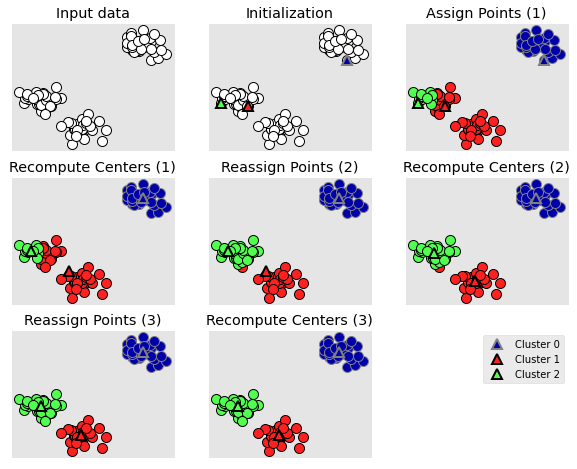

In [5]:
mglearn.plots.plot_kmeans_algorithm()

## ***Método $k$-means***

Vamos a hacer uso de [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) para realizar el $k$-means clustering.

## ***Ejemplo 1.***

In [6]:
USArrests = pd.read_csv(url_base + "USArrests.csv", index_col=0)
USArrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [7]:
## Escalamos la información.
scaler = StandardScaler()
scaler.fit(USArrests)
##
df = pd.DataFrame(scaler.transform(USArrests), columns = USArrests.columns, index = USArrests.index)
df.head(6)

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814
Colorado,0.025976,0.402909,0.869548,1.883901


In [8]:
n = 2
kmeans = KMeans(n_clusters=n,                  ### Número de clusters
                random_state=0)                ### Semilla aleatoria.
kmeans.fit(df)                                 ### Ajustamos el modelo.

KMeans(n_clusters=2, random_state=0)

In [9]:
## Atributos.
print(kmeans.inertia_)
print(kmeans.cluster_centers_)

104.96163315756871
[[-0.67675778 -0.68274685 -0.13306084 -0.57037591]
 [ 1.01513667  1.02412028  0.19959126  0.85556386]]


In [10]:
centroides = pd.DataFrame(kmeans.cluster_centers_, columns = df.columns)
centroides

,Murder,Assault,UrbanPop,Rape
0,-0.676758,-0.682747,-0.133061,-0.570376
1,1.015137,1.024120,0.199591,0.855564


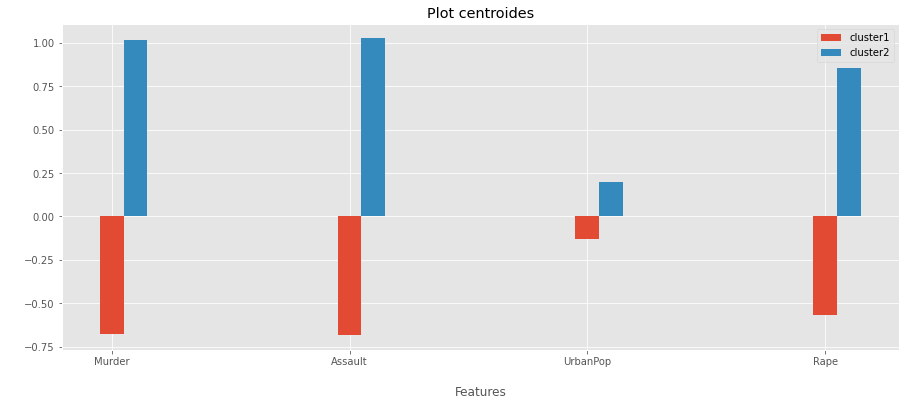

In [11]:
## Plot centroides.
temp = centroides.iloc[0:4,0:5]
temp.index = ["cluster1","cluster2"]
X_axis, a = np.arange(len(temp.columns)), np.flip(np.arange(-0.1,0.1,0.1))
##
for i,index in enumerate(temp.index):
  plt.bar(X_axis -1*a[i], temp.loc[index],width=0.1, label = index)
plt.xticks(X_axis,temp.T.index)
plt.xlabel("\nFeatures",)
plt.ylabel(" ",)
plt.title("Plot centroides")
plt.legend()
plt.show()

In [12]:
## Atributos.
print(kmeans.labels_)

[1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0]


In [13]:
df_cluster = USArrests.copy()
df_cluster["cluster"] = kmeans.labels_
df_cluster

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,1
Alaska,10.0,263,48,44.5,1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1
Colorado,7.9,204,78,38.7,1
Connecticut,3.3,110,77,11.1,0
Delaware,5.9,238,72,15.8,0
Florida,15.4,335,80,31.9,1
Georgia,17.4,211,60,25.8,1


In [14]:
df_cluster.groupby(by = ["cluster"]).mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
0,4.870,114.433333,63.633333,15.943333
1,12.165,255.250000,68.400000,29.165000


In [15]:
n = 4
kmeans1 = KMeans(n_clusters=n,                  ### Número de clusters
                random_state=0)                 ### Semilla aleatoria.
kmeans1.fit(df)                                 ### Ajustamos el modelo.

KMeans(n_clusters=4, random_state=0)

In [16]:
print(kmeans1.inertia_)
print(kmeans1.cluster_centers_)

57.55425863091105
[[-0.49440658 -0.3864845   0.58167593 -0.26431024]
 [ 0.70212683  1.04999438  0.72997363  1.28990383]
 [-0.97130281 -1.11783581 -0.93954982 -0.97657842]
 [ 1.42622412  0.88321132 -0.82279055  0.01946669]]


In [17]:
kmeans.predict(df)

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
temp = pd.DataFrame(kmeans.transform(df),)
temp["cluster"] = kmeans.predict(df)
temp["cluster"] = temp["cluster"].astype("category")
temp.head()

,0,1,cluster
0,2.525795,1.173345,1
1,3.915857,2.241206,1
2,3.039746,1.343111,1
3,1.649881,1.992482,0
4,3.933386,2.147210,1


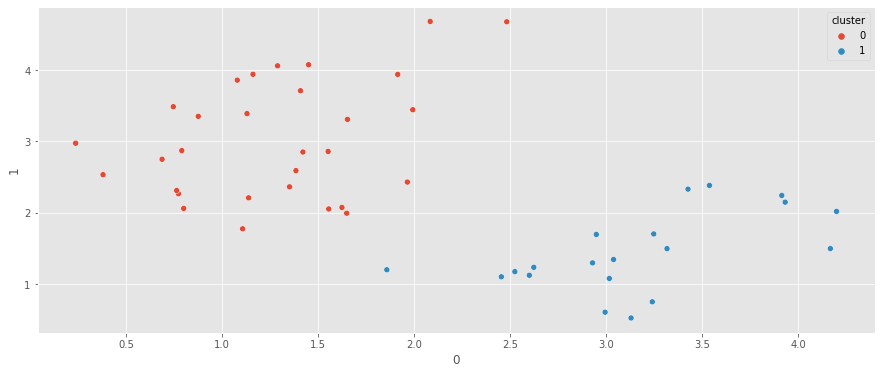

In [19]:
sns.scatterplot(data = temp, x = 0, y = 1,hue = "cluster")
plt.show()

## ***¿Cuántos cluster debemos seleccionar?***

Determinar el número óptimo de clusters en un Dataset es un problema fundamental en el agrupamiento. En $k$-means se requiere especificar de antemano el número de clústeres $k$ que se generarán.

Desafortunadamente no hay una respuesta definitiva a esta pregunta. El número óptimo de clusters es algo subjetivo y depende del método utilizado para medir
similitudes y los parámetros utilizados para la partición.

Una solución simple y popular consiste en inspeccionar el dendrograma producido por el agrupamiento jerárquico para ver si sugiere un número particular de grupos, de igual forma este enfoque también es subjetivo.

Vamos a describir diferentes métodos para determinar el número óptimo de clusters para $k$-means. Estos métodos incluyen métodos directos y métodos de prueba estadísticos:

1. Métodos directos: consiste en optimizar un criterio, como el ***WCSS*** o la silueta media. Los métodos se denominan ***elbow method*** y ***silhouette***, respectivamente.

2. Métodos estadísticos de contraste: consiste en comparar la evidencia contra la hipótesis nula. Un ejemplo es la estadística de [***GAP***]().


### ***Método del codo.***


La idea básica detrás de los método $k$-means, es definir clusters tales que ***WCSS*** se minimiza. Recordemos que ***WCSS*** mide la compacidad del agrupamiento y queremos que sea lo más pequeño posible.

El método codo analiza el ***WCSS*** como una función del número de clusters. Se debe elegir una cantidad de clusers de tal forma que agregar otro cluster no mejore mucho el valor ***WCSS***.

El número óptimo de clústeres se puede definir de la siguiente manera:

1. Calcule el algoritmo de clustering $k$-means para diferentes valores de $k$. Puede variar $k$ de 1 a 10 grupos.

2. Para cada $k$, calcule ***WCSS***.

3. Trazar la curva de ***WCSS*** según el número de clusters $k$.

4. La ubicación de una curva (codo) en el plot generalmente se considera como un indicador del número adecuado de clusters.

Tenga en cuenta que el método del codo a veces es ambiguo.

In [20]:
def elbow_plot(df,n=2):
  """
      Función que plotea el número de cluster vs WCSS  buscando determinar el número de cluster óptimo.
      * Input: ---> df: pd.DataFrame con quien se ajusta el algoritmo k-means.
               ---> n (int): Número de cluster a comparar. Default 2.
      * Output: None

      ** Nota: Esta función depende de sklearn-KMeans y ploty_express***
  """
  from sklearn.cluster import KMeans
  inertias = [KMeans(n_clusters=k).fit(df).inertia_ for k in range(1,n+1)]
  data_plot = pd.DataFrame({"n_clusters":range(1,n+1),"WCSS":inertias})
  fig = px.line(data_plot, x="n_clusters", y = "WCSS",  title = "Optimal number of clusters",
                template="plotly_white", markers=True)
  fig.update_xaxes(title_text = "Number of clusters")
  fig.update_yaxes(title_text = "WCSS")
  fig.show()
  return None

elbow_plot(df,n=10)

***Según lo observado, ¿cuántos cluster usted considera que se deben formar?***

### ***Coeficiente de silhouette***


El coeficiente de silueta mide qué tan bien se agrupa una observación y estima la ***distancia promedio entre clusters***. El plot de silueta muestra una medida de qué tan cerca está cada punto en un cluster de los puntos en los clusters vecinos.

Para cada observación $i$, el ancho de la silueta $s_i$ se calcula de la siguiente manera:

1. Para cada observación $i$, calculamos la disimilitud (distancia) promedio $a_i$ entre $i$ y todos los otros puntos del clúster al que pertenezca $i$.

2. Para todos los demás clusters $C$, a los que no pertenezca $i$, calcule el promedio de disimilitud $d(i,C)$ de $i$ con todos los puntos de $C$. La menor de estas $d(i,C)$ se define como $b_i = min_C\  d(i,C)$. El valor de $b_i$ puede verse como la disimilitud promedio entre $i$ y su cluster "vecino", es decir, el más cercano al que ***no*** pertenece.

3. Finalmente, el ancho de la silueta de la observación $i$ se define mediante la fórmula:
$$S_i = \frac{(b_i - a_i)}{max(a_i, b_i)}$$

El ancho de la silueta se puede interpretar de la siguiente manera:

- Las observaciones con un $S_i$ grande (casi 1) están muy bien agrupadas.

- Un $S_i$ pequeño (alrededor de 0) significa que la observación se encuentra entre dos grupos.

- Las observaciones con un $S_i$ negativo probablemente estén ubicadas en el cluster incorrecto.



El algoritmo es similar al método del codo y se puede calcular de la siguiente manera:
1. Calcule el algoritmo $k$-means  para diferentes valores de $k$. Por ejemplo, variando $k$ de 1 a 10 grupos.

2. Para cada $k$, calcule la silueta promedio de las observaciones.

3. Trazar el plot según el número de clusters y la silueta promedio.

4. La ubicación del máximo se considera como el número apropiado de clusters.

In [21]:
print("Con 2 clusters el coeficiente de silueta es:",silhouette_score(df, kmeans.labels_))
print("Con 4 clusters el coeficiente de silueta es:",silhouette_score(df, kmeans1.labels_))

Con 2 clusters el coeficiente de silueta es: 0.4084890326217641
Con 4 clusters el coeficiente de silueta es: 0.33968891433344395


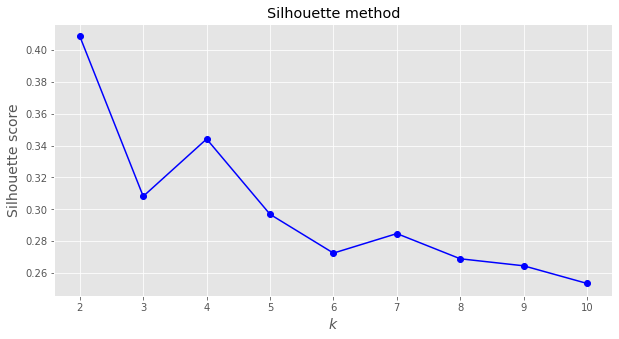

In [22]:
def plot_silhouette(df,n=2, height = 5, width = 3):
  from sklearn.metrics import silhouette_score
  from sklearn.cluster import KMeans
  models = [KMeans(n_clusters=n).fit(df) for n in range(2,n+1)]
  silhouette_scores = [silhouette_score(df, model.labels_) for model in models]
  plt.figure(figsize=(width, height))
  plt.plot(list(range(2, n+1)), silhouette_scores, "bo-")
  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)
  plt.title("Silhouette method")
  plt.show()
  
  return None

plot_silhouette(df,n=10, width = 10)

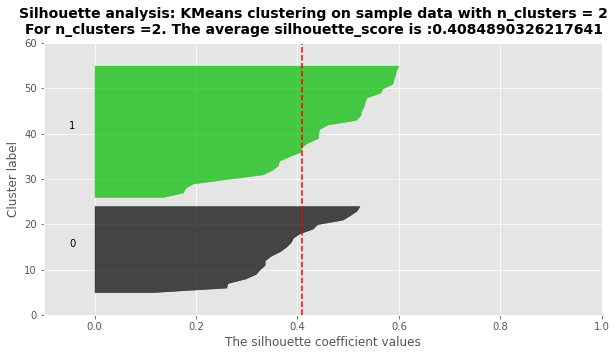

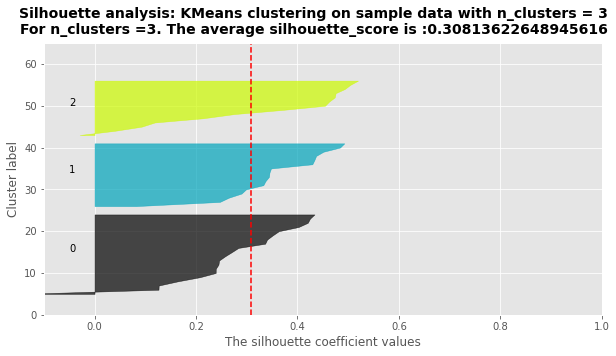

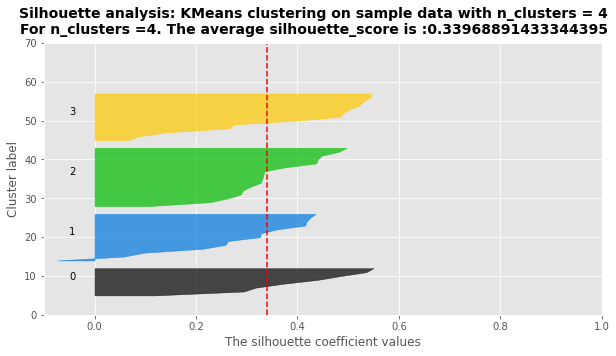

In [23]:
### Plot de silueta de sklearn
range_n_clusters = [2,3,4]
for n_clusters in range_n_clusters:
    plt.figure(figsize=(10,5))
    plt.ylim([0, len(df) + (n_clusters + 1)*10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    text = f"For n_clusters ={n_clusters}. The average silhouette_score is :{silhouette_avg}"
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)
    y_lower = 5
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7,)
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 1  # 10 for the 0 samples
    plt.xlim([-0.1, 1])
    plt.ylim([0, df.shape[0]+ n_clusters*5])
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.suptitle("Silhouette analysis: KMeans clustering on sample data with n_clusters = %d"
                  % n_clusters + "\n" + text,fontsize=14, fontweight="bold",)
plt.show()

Note que en este caso una elección de 2 grupos no presenta problemas de mala asignación, tenga en cuenta que en este caso además los grupos están desbalanceados. Para el caso de 3 clusters, hay 2 en donde tenemos mala asignación de cluster. Para el caso de 4 clusters se tiene ubicación no adecuada en elements de un clusters pero los grupos están balanceados. Parace ser pertinente seleccionar 2 o 4 clusters. El criterio estricto, nos diría que la mejor elección son ***2 clusters.***

### ***GAP Statistic***

Este estadístico compara, para diferentes valores de $k$, el ***WCSS*** observado frente al valor esperado acorde a una distribución uniforme de referencia. La estimación del número óptimo de clusters es el valor $k$ con el que se consigue maximizar el estadístico ***GAP***, es decir, encuentra el valor de $k$ con el que se consigue una estructura de clusters lo más alejada posible de una distribución uniforme aleatoria. Este método puede aplicarse a cualquier tipo de clustering.

El algoritmo del gap statistic method es el siguiente:

1. Hacer clustering de los datos para un rango de valores de $k$ y calcular para cada uno el valor de ***WCSS***.

2. Simular $B$ sets de datos de referencia, todos ellos con una distribución aleatoria uniforme. Aplicar clustering a cada uno de los sets con el mismo rango de valores $k$ empleado en los datos originales, calculando en cada caso $W_{kb}$. Se recomienda emplear valores de $B=500$.

3. Calcular el estadístico ***GAP*** para cada valor de $k$ como la desviación de la varianza observada ***WCSS*** respecto del valor esperado acorde a la distribución de referencia $W_{kb}$.

$$GAP(k)=\frac{1}{B}\sum_{b=1}^{B}log(W_{kb})−log(WCSS)$$

La estimación de los clústeres óptimos será el valor que maximice la estadística de ***GAP***.

In [24]:
# Gap Statistic for K means
## Tomado de 
## https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number
## -of-clusters-in-python-898241e1d6ad
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: pd.DataFrame with the number of cluster and gap statistic.
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape) 
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.mean(np.log(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)        
    return resultsdf

In [ ]:
df1 = optimalK(df, nrefs=25,)
###
plt.plot(df1["clusterCount"], df1["gap"], linestyle="--", marker="o", color="b")
plt.xlabel("Number of clusters $K$")
plt.title("Gap Statistic method")
plt.ylabel("Gap Statistics")
plt.show()

En este caso el caso el número de clusters a selecionar debe ser de ***4 clusters.***

## ***Visualización de los cluster.***

Vamos a hacer uno del `PCA` para lograr visualizar los cluster.

In [ ]:
pca = PCA(n_components=0.99)
pca.fit(df)
pca_array = pca.transform(df)                                

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

Notemos que con 2 componentes principales se retiene un $86.7\%$ de la variabilidad total de los datos.

In [ ]:
## Vía componentes principales seleccionamos la cantidad de clusters.
kmeans = KMeans(n_clusters=2,
                random_state=0)
kmeans.fit(df)

In [ ]:
data_PCA = pd.DataFrame(pca_array, index = df.index, columns = ["PC1","PC2","PC3","PC4"])
data_PCA["cluster"] = kmeans.labels_
data_PCA

In [ ]:
## Plot con 2 clusters.
cluster_biplot(pca,USArrests,kmeans.labels_,size_text=5)

In [ ]:
## Consideremos 4 clusters.
kmeans1 = KMeans(n_clusters=4,random_state=0).fit(df); kmeans1

In [ ]:
## Plot con 4 clusters.
cluster_biplot(pca,USArrests,kmeans1.labels_,size_text=6)

## ***¿Como caracterizar los clusters?***

### ***Caso 2 clusters.***

In [ ]:
n = 2
kmeans = KMeans(n_clusters=n,                  ### Número de clusters
                random_state=0)                ### Semilla aleatoria.
kmeans.fit(df)                                 ### Ajustamos el modelo.

In [ ]:
## Caso 2 clusters
df_Clusters2 = USArrests.copy()
df_Clusters2["cluster"] = kmeans.labels_
df_Clusters2["cluster"] = df_Clusters2["cluster"].astype("category")
df_Clusters2.head()

In [ ]:
## Box-plots
fig, axes = plt.subplots(2,2, sharex=True)
##
sns.boxplot(data=df_Clusters2, x = "cluster", y = "Murder", ax = axes[0,0])
sns.boxplot(data=df_Clusters2, x = "cluster", y = "Assault", ax = axes[0,1])
sns.boxplot(data=df_Clusters2, x = "cluster", y = "UrbanPop", ax = axes[1,0])
sns.boxplot(data=df_Clusters2, x = "cluster", y = "Rape", ax = axes[1,1])
plt.show()

***Comentarios:***

1. El cluster 1 tiene una alta tasa delictiva y predomina la población urbana.

2. El cluster 0 tiene tasas bajas de delitos y una menor tasa que el cluster 1 de población urbana.

Note que la solución en este caso es bastante simple, pues solo está teniendo en consideración las tasas de crimenes altos con "población urbana" y tasa de crimenes bajos con "población rural". Esta solución parece ser buena, pues logra identificar los estados que tienen alto y bajo crimen.

### ***Caso 4 clusters.***

In [ ]:
n = 4
kmeans = KMeans(n_clusters=n,                  ### Número de clusters
                random_state=0)                ### Semilla aleatoria.
kmeans.fit(df)                                 ### Ajustamos el modelo.

In [ ]:
## Caso 2 clusters
df_Clusters4 = USArrests.copy()
df_Clusters4["cluster"] = kmeans.labels_
df_Clusters4.head()

In [ ]:
## Box-plots
fig, axes = plt.subplots(2,2, sharex=True)
##
sns.boxplot(data=df_Clusters4, x = "cluster", y = "Murder", ax = axes[0,0])
sns.boxplot(data=df_Clusters4, x = "cluster", y = "Assault", ax = axes[0,1])
sns.boxplot(data=df_Clusters4, x = "cluster", y = "UrbanPop", ax = axes[1,0])
sns.boxplot(data=df_Clusters4, x = "cluster", y = "Rape", ax = axes[1,1])
fig.suptitle("Boxplot para features para 2 Clusters", fontsize=14, fontweight="bold",)
plt.show()

***Comentarios:***

1. El cluster 3 tiene alto el índice de asesinatos. El cluster 2 tiene un menor índice de asesinatos.

2. `Assault` y `Murder` tiene un comportamiento similar para los clusters.

4. Note que el cluster 1 tiene una tasa más alta de asaltos que el cluster 3. A su vez el cluster 3 tiene más asesinatos. Los clusters 0 y 2 tiene un compartamiento similar en ambas features (`Assault` y `Murder`).

5. En cuanto a `UrbanPop` el cluster 0 y tienen cluster 1 tiene las tasas más altas. Por su supuesto los individuos en los cluster 2 y 3 tiene una tasa baja de población urbana.

Note que podemos caracterizar los cluster así:

- ***Cluster 0:*** Baja tasa de delitos, y una alta tasa de población urbana.

- ***Cluster 1.*** Alta tasa en todas las features.

- ***Cluster 2.*** Baja tasa en todas las features.

- ***Cluster 3.*** Alta tasa de `Murder` y `Assault` con baja tasa de población urbana y violaciones.

Esta solución parece ser buena, en este caso podemos pensar en una segmentación basados en la feature `UrbanPop`, note que acá tenemos más información que con 2 clusters.

## ***Referencias:***

1. _Análisis estadístico de datos multivariados. Díaz L & Morales M. Editorial: Publicaciones Facultad de ciencias. UNAL._

2. _Multivariate Analysis I. Kassambara A. Disponible en: http://www.sthda.com/english/_

3. [_Selecting the number of clusters with silhouette analysis on KMeans clustering_](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) [_by sklearn_](https://scikit-learn.org/stable/)